<a href="https://colab.research.google.com/github/neimarcos/Mestrado/blob/main/maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install basemap
!pip install pyproj==1.9.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 10.9 MB/s 
     |████████████████████████████████| 6.3 MB 23.7 MB/s 
     |████████████████████████████████| 219 kB 55.5 MB/s 
     |████████████████████████████████| 30.5 MB 2.0 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=fe83953e2cc828eeda32f397afd56c67e4f043208047d76771ff74708ab64fb2
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 10.9 MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp37-cp37m-linux_x86_64.whl size=3702494 sha256=18a064cab6f6bb62d1c091d4898a63228f19452b656fad9be0a4b776ebb441cf
  Stored in directory: /root/.cache/pip/wheels/08/60/55/38382877bab48a6abfca7bd66115e287ce5a9530cbce631771
Successfully built pyproj
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.2.1
    Uninstalling pyproj-3.2.1:
      Successfully uninstalled pyproj-3.2.1


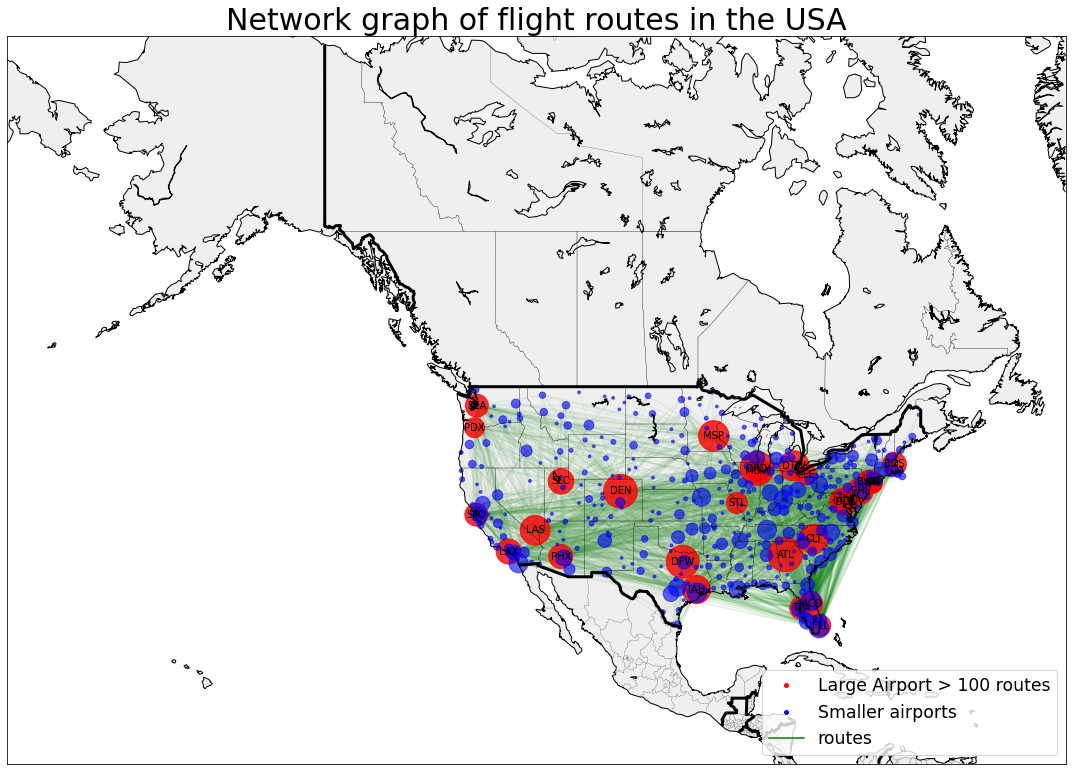

successful visualization
['ABE', 'ATL', 'CLT', 'DTW', 'MYR', 'ORD', 'PGD', 'PHL', 'PIE', 'SFB', 'ABI', 'DFW', 'ABL', 'OTZ', 'SHG', 'ABQ', 'BWI', 'CNM', 'DAL', 'DEN', 'HOU', 'IAH', 'JFK', 'LAM', 'LAS', 'LAX', 'MCI', 'MDW', 'MSP', 'OAK', 'PDX', 'PHX', 'SAN', 'SEA', 'SFO', 'SLC', 'ABR', 'ABY', 'ACK', 'BOS', 'EWB', 'HPN', 'HYA', 'MVY', 'TEB', 'ACT', 'ACV', 'CEC', 'SMF', 'ACY', 'FLL', 'MCO', 'RSW', 'TPA', 'ADK', 'ANC', 'ADQ', 'AKK', 'KLN', 'AET', 'BTT', 'FAI', 'HUS', 'AEX', 'AGS', 'DCA', 'AHN', 'BNA', 'AIA', 'CDR', 'AIN', 'ATK', 'BRW', 'AKB', 'DUT', 'AKN', 'DLG', 'PIP', 'WSN', 'AKP', 'ALB', 'CLE', 'EWR', 'IAD', 'MSS', 'OGS', 'ALO', 'ALS', 'FMN', 'ALW', 'AMA', 'ANI', 'BET', 'CDB', 'CDV', 'ENA', 'HNL', 'HOM', 'ILI', 'JNU', 'KSM', 'MCG', 'OME', 'SCC', 'SDP', 'SNP', 'STG', 'UNK', 'VDZ', 'CHU', 'HCR', 'KLG', 'RSH', 'SHX', 'ANV', 'AOO', 'JST', 'APF', 'MIA', 'APN', 'ARC', 'VEE', 'ART', 'ASE', 'ATW', 'AUS', 'AVL', 'AVP', 'AZO', 'BDL', 'BHM', 'BMI', 'BQK', 'BTR', 'BTV', 'BUF', 'CAE', 'CAK', 'CHA', '

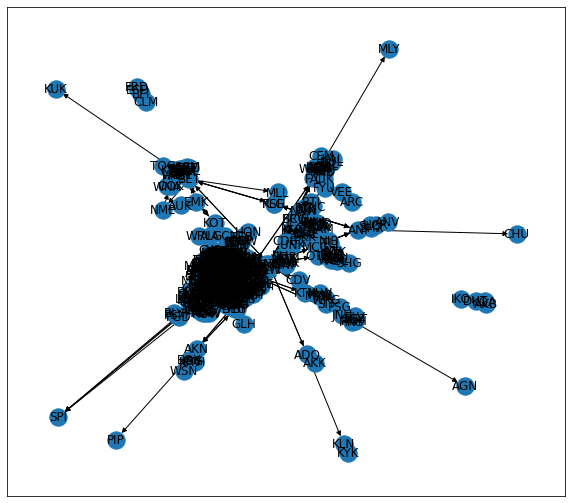

NetworkXError: ignored

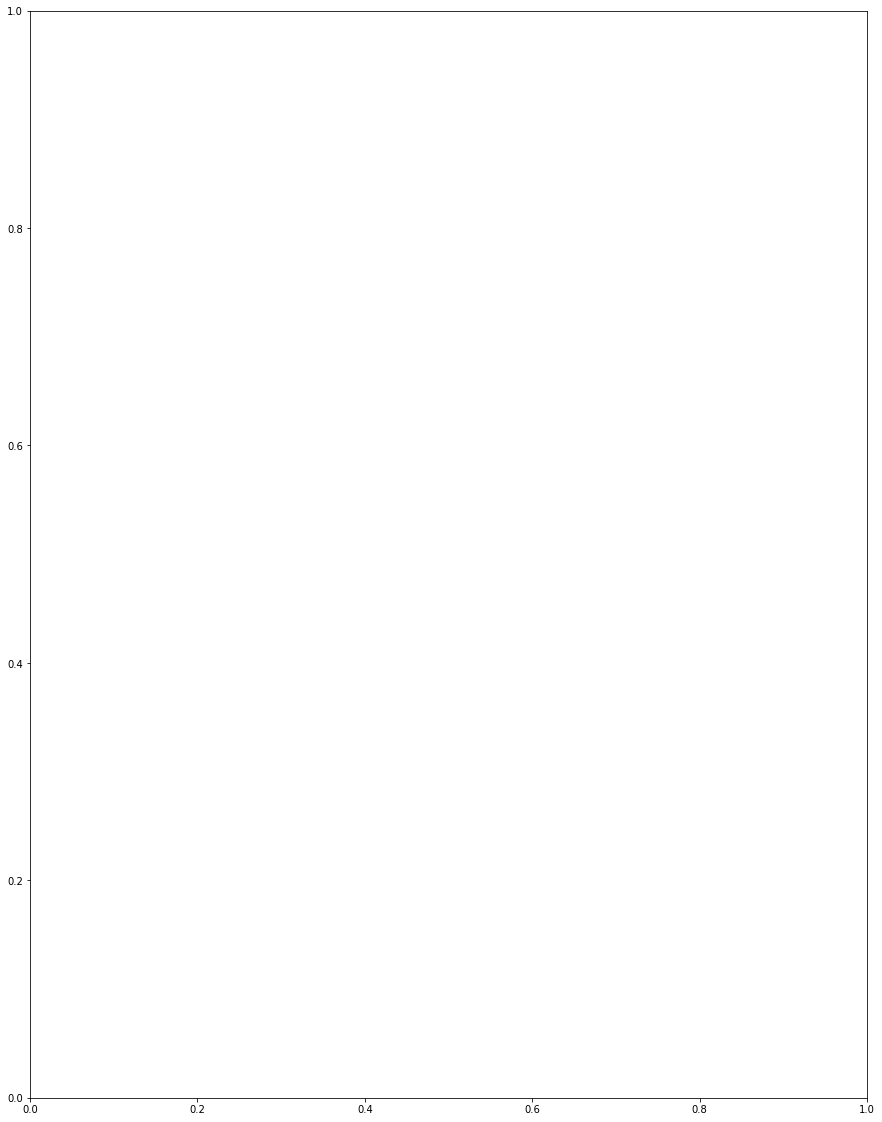

In [ ]:
# import libaries
import pandas as pd
import numpy as np
import networkx as nx
import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines

def main():
	# download airport info data
	airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
	airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)

	# download flight routes data
	route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
	              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
	routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
	                        names = route_cols)
	#clean up data, change 'object' type to numeric and drops NaNs
	routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
	routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
	routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 

	advanced_visualization(airport_df, routes_df)
	simple_visualization(airport_df, routes_df)


##### Part 1: simple network visualization, Alaska and other non-mainlain territories included ####
###################################################################################################
# extract country and then extra columns
def simple_visualization (airport_df, routes_df):
	if (airport_df is None) or (routes_df is None):
		print ('Data cannot be retrieved and read')
	else:
		airport_us = airport_df[(airport_df.Country == "United States")][['Name','Lat', 'Long', 'IATA', 'ICAO']]
		us_airport_ix = airport_us.index.values
		routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
		                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA
		routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
		# to find number of flights in and out of an airport
		# it is similar to find number of rows in which each airport occur in either one of the 2 columns
		counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
		# create a data frame of position based on names in count
		counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
		pos_data = counts.merge(airport_us, on = 'IATA')

		graph = nx.from_pandas_edgelist(routes_us, source = 'Source Airport', target = 'Dest Airport',
		                        edge_attr = 'counts',create_using = nx.DiGraph())
		print (graph.nodes())
		# Create graph
		# default graph using Networkx inbuilt graph tools
		plt.figure(figsize = (10,9))
		nx.draw_networkx(graph)
		plt.savefig("map_0.png", format = "png", dpi = 300)
		plt.show()

		# Set up base map
		plt.figure(figsize=(15,20))
		m = Basemap(
		        projection='merc',
		        llcrnrlon=-180,
		        llcrnrlat=10,
		        urcrnrlon=-50,
		        urcrnrlat=70,
		        lat_ts=0,
		        resolution='l',
		        suppress_ticks=True)

		# import long lat as m attribute
		mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
		pos = {}

		for count, elem in enumerate (pos_data['IATA']):
		    pos[elem] = (mx[count], my[count])
		
		# draw nodes and edges and over aly on basemap
    	
		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), node_color = 'r', alpha = 0.8,
		                       node_size = [counts['total_flight'][s]*3 for s in graph.nodes()])
		nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', width = routes_us['counts']*0.75, 
		                       alpha=0.2, arrows = False)

		m.drawcountries(linewidth = 3)
		m.drawstates(linewidth = 0.2)
		m.drawcoastlines(linewidth=3)
		plt.tight_layout()
		plt.savefig("map_2.png", format = "png", dpi = 300)
		plt.show()
		print ("successful visualization")
		return 0

##### Part 2: more on visualization, only mainlain territories with more features ####
######################################################################################
# extract country and then extra columns
def advanced_visualization (airport_df, routes_df):
	if (airport_df is None) or (routes_df is None):
		print ("Data cannot be retrieved and read")
	else:
		airport_us = airport_df[(airport_df.Country == "United States") & (airport_df.Lat > 25) 
								& (airport_df.Lat < 50) & (airport_df.Long > -130) & (airport_df.Long < -60)]
		us_airport_ix = airport_us.index.values
		routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
		                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA
		routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
		# to find number of flights in and out of an airport
		# it is similar to find number of rows in which each airport occur in either one of the 2 columns
		counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
		# create a data frame of position based on names in count
		counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
		pos_data = counts.merge(airport_us, on = 'IATA')

		# Create graph
		graph = nx.from_pandas_edgelist(routes_us, source = 'Source Airport', target = 'Dest Airport',
		                        edge_attr = 'counts',create_using = nx.DiGraph())

		# Set up base map
		plt.figure(figsize=(15,20))
		m = Basemap(
		        projection='merc',
		        llcrnrlon=-180,
		        llcrnrlat=10,
		        urcrnrlon=-50,
		        urcrnrlat=70,
		        lat_ts=0,
		        resolution='l',
		        suppress_ticks=True)

		# import long lat as m attribute
		mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
		pos = {}
		for count, elem in enumerate (pos_data['IATA']):
		    pos[elem] = (mx[count], my[count])

		# draw nodes and edges and overly on basemap
		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 100],
		                       node_color = 'r', alpha = 0.8,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 100])

		nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
		                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 100})

		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 100],
		                       node_color = 'b', alpha = 0.6,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 100])

		nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = routes_us['counts']*0.75, 
		                       alpha=0.06, arrows = False)

		m.drawcountries(linewidth = 3)
		m.drawstates(linewidth = 0.2)
		m.drawcoastlines(linewidth=1)
		m.fillcontinents(alpha = 0.3)
		line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
		line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
		line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
		plt.legend((line1, line2, line3), ('Large Airport > 100 routes', 'Smaller airports', 'routes'),
		           loc=4, fontsize = 'xx-large')
		plt.title("Network graph of flight routes in the USA", fontsize = 30)
		#m.bluemarble()
		plt.tight_layout()
		plt.savefig("map_3.png", format = "png", dpi = 300)
		plt.show()
		print ("successful visualization")
		return 0

if __name__ == "__main__":
    main()  
